In [1]:
import sys
sys.path.append("../")

from scripts.direct_training import direct_training
from scripts.fine_tuning import fine_tuning

pre_trained = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        n_train=10_000,
    )
)

pre_trained_models = {
    row.labels: row.id for row in pre_trained.itertuples()
}
pre_trained_models

{'ace': '23.06.08-20.33.15-394025',
 'gap20': '23.06.09-08.13.03-677890',
 'edip': '23.06.09-22.16.54-046769',
 'qsnap': '23.06.11-06.00.35-238778',
 'lcbop': '23.06.13-08.37.46-604921'}

In [2]:
import pandas as pd
from IPython.display import display

finetuned_results = {}

for label, id in pre_trained_models.items():
    df = fine_tuning.to_dataframe(
        config=dict(
            pretrain_id=id,
            finetune_dataset="C-GAP-17",
            finetune_labels="dft",
            checkpoint="best",
        )
    )
    df = df[df.seed.isin((1, 2, 42))]
    finetuned_results[label] = df

pd.DataFrame({
    label: df.groupby("n_finetune").count().id
    for label, df in finetuned_results.items()
    if label != "qsnap"
}).T

n_finetune,25,50,100,200,400,800,1600,3200
ace,3,3,3,3,3,3,3,3
gap20,3,3,3,3,3,3,3,3
edip,3,3,3,3,3,3,3,3
lcbop,3,3,3,3,3,3,3,3


In [3]:
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft",
    )
)

direct_results = direct_results[direct_results.seed.isin((1, 2, 42))]

pd.DataFrame(direct_results.groupby("n_train").count().id).T

n_train,25,50,100,200,400,800,1600,3200
id,3,3,3,3,3,3,3,3


In [4]:
import matplotlib.pyplot as plt

def cleanup(ax, yticks=None):
    xticks = list(direct_results.n_train.unique())
    ax.set_xscale("log")
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel("Number of Training Structures")

    if yticks is None:
        yticks = [round(y) for y in ax.get_yticks()]
    ax.set_yscale("log")
    ax.set_yticks(yticks, yticks)

    ax.minorticks_off()
    # move spines apart
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])


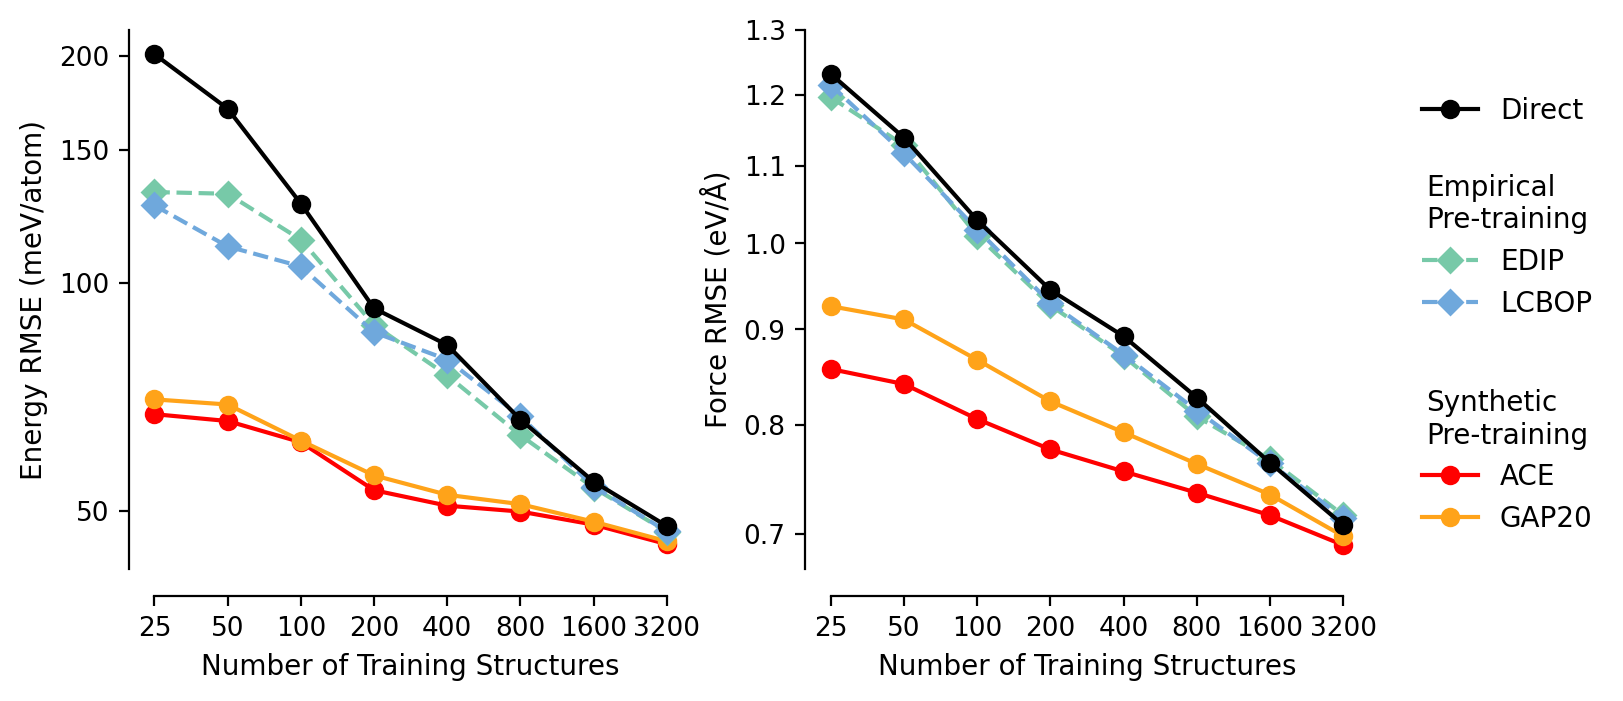

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours, empirical as empirical_labels, synthetic as synthetic_labels
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(style_defaults)

fig, (energy_ax, force_ax ) = plt.subplots(ncols=2, figsize=(8, 3.5))

direct_style = "-o"
empirical_style = "--D"
synthetic_style = "-o"

## DIRECT TRAINING

lines = defaultdict(dict)

def plot_results(results, style, colour):
    col_name = "n_train" if "n_train" in results else "n_finetune"
    results = results.groupby(col_name)[["test_per_atom_energy_rmse", "test_force_rmse"]].min().reset_index()
    energy_ax.plot(
        results[col_name],
        results.test_per_atom_energy_rmse * 1000,
        style,
        color=colour,
    )

    line, = force_ax.plot(
        results.n_train if "n_train" in results else results.n_finetune,
        results.test_force_rmse,
        style,
        color=colour,
    )
    return line



## FINETUNING

for label, results in finetuned_results.items():
    if label == "qsnap":
        continue
    colour = colours[label]
    style = synthetic_style if label in synthetic_labels else empirical_style
    flag = "synthetic" if label in synthetic_labels else "empirical"
    lines[flag][label] = plot_results(results, style, colour)

direct_line = plot_results(direct_results, direct_style, colours["dft"])

cleanup(energy_ax, yticks=[50, 100, 150, 200])
energy_ax.set_ylabel("Energy RMSE (meV/atom)")
cleanup(force_ax, yticks=[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
force_ax.set_ylabel("Force RMSE (eV/Å)")

direct_leg = plt.legend(
    (direct_line,),
    ("Direct",),
    bbox_to_anchor=(1.05, 0.85),
    loc="center left",
    fancybox=False,
)


emp_leg = plt.legend(
    lines["empirical"].values(),
    [l.upper() for l in lines["empirical"].keys()],
    title="Empirical\nPre-training",
    bbox_to_anchor=(1.05, 0.6),
    loc="center left",
    fancybox=False,
)


syn_leg = plt.legend(
    lines["synthetic"].values(),
    [l.upper() for l in lines["synthetic"].keys()],
    title="Synthetic\nPre-training",
    bbox_to_anchor=(1.05, 0.2),
    loc="center left",
    fancybox=False,
)

fig.add_artist(direct_leg)
fig.add_artist(emp_leg)

plt.savefig("../figures/pre-train-source.svg", bbox_inches="tight", transparent=True)

# Table Generation

In [6]:
finetuned_results = {}

for label, id in pre_trained_models.items():
    df = fine_tuning.to_dataframe(
        config=dict(
            pretrain_id=id,
            finetune_dataset="C-GAP-17",
            finetune_labels="dft",
            checkpoint="best",
        )
    )
    df = df[df.seed.isin((1, 2, 42))]
    finetuned_results[label] = df

def get_performance(df, metric, groupby="n_finetune"):
    result = df.groupby(groupby)[metric].agg(["mean", "std"]).reset_index()
    return (result["mean"] * 1000).round(1).astype(str) + " ± " + (result["std"] * 1000).round(1).astype(str)

df = pd.DataFrame({
    label: get_performance(df, "test_per_atom_energy_rmse", groupby="n_finetune")
    for label, df in finetuned_results.items()
    if label != "qsnap"
}).T
df.columns = [25,50,100,200,400,800, 1600, 3200]

# get the same for the direct results
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft",
    )
)

direct_results = direct_results[direct_results.seed.isin((1, 2, 42))]

direct_df = pd.DataFrame({
    "direct": get_performance(direct_results, "test_per_atom_energy_rmse", groupby="n_train"),
}).T
direct_df.columns = [25,50,100,200,400,800, 1600, 3200]

df = pd.concat([df, direct_df])
df = df.T[["direct", "edip", "lcbop", "gap20", "ace"]]
df

,direct,edip,lcbop,gap20,ace
25,206.8 ± 9.4,133.9 ± 2.1,129.7 ± 3.1,72.1 ± 2.7,68.8 ± 1.9
50,176.0 ± 5.2,136.9 ± 5.5,116.4 ± 4.2,70.0 ± 1.6,68.5 ± 3.0
100,132.3 ± 4.2,115.8 ± 1.4,109.3 ± 6.7,63.1 ± 1.0,62.5 ± 1.6
200,96.5 ± 3.6,90.5 ± 3.1,87.2 ± 1.0,55.8 ± 0.1,53.5 ± 0.3
400,85.9 ± 3.6,84.1 ± 7.5,81.1 ± 1.7,52.5 ± 0.0,51.7 ± 0.8
800,69.0 ± 3.4,77.6 ± 24.0,67.3 ± 0.8,51.5 ± 0.9,51.0 ± 1.6
1600,56.6 ± 1.7,58.2 ± 4.1,54.9 ± 1.2,49.3 ± 1.1,48.1 ± 0.1
3200,52.9 ± 7.9,108.2 ± 94.1,48.1 ± 1.2,45.9 ± 0.5,45.3 ± 0.2


In [7]:
# convert the ^df into a latex table
print(df.style.to_latex().replace("±", "$\pm$"))

\begin{tabular}{llllll}
 & direct & edip & lcbop & gap20 & ace \\
25 & 206.8 $\pm$ 9.4 & 133.9 $\pm$ 2.1 & 129.7 $\pm$ 3.1 & 72.1 $\pm$ 2.7 & 68.8 $\pm$ 1.9 \\
50 & 176.0 $\pm$ 5.2 & 136.9 $\pm$ 5.5 & 116.4 $\pm$ 4.2 & 70.0 $\pm$ 1.6 & 68.5 $\pm$ 3.0 \\
100 & 132.3 $\pm$ 4.2 & 115.8 $\pm$ 1.4 & 109.3 $\pm$ 6.7 & 63.1 $\pm$ 1.0 & 62.5 $\pm$ 1.6 \\
200 & 96.5 $\pm$ 3.6 & 90.5 $\pm$ 3.1 & 87.2 $\pm$ 1.0 & 55.8 $\pm$ 0.1 & 53.5 $\pm$ 0.3 \\
400 & 85.9 $\pm$ 3.6 & 84.1 $\pm$ 7.5 & 81.1 $\pm$ 1.7 & 52.5 $\pm$ 0.0 & 51.7 $\pm$ 0.8 \\
800 & 69.0 $\pm$ 3.4 & 77.6 $\pm$ 24.0 & 67.3 $\pm$ 0.8 & 51.5 $\pm$ 0.9 & 51.0 $\pm$ 1.6 \\
1600 & 56.6 $\pm$ 1.7 & 58.2 $\pm$ 4.1 & 54.9 $\pm$ 1.2 & 49.3 $\pm$ 1.1 & 48.1 $\pm$ 0.1 \\
3200 & 52.9 $\pm$ 7.9 & 108.2 $\pm$ 94.1 & 48.1 $\pm$ 1.2 & 45.9 $\pm$ 0.5 & 45.3 $\pm$ 0.2 \\
\end{tabular}

